In [20]:
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\"
os.chdir(target_dir)

In [8]:
%%capture
%run "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\quail" "conduit.py"
# Run Quail (line magics must be written first)
# Outputs to files specified in conduit.py

# Import in post
import processing.readwritedatafiles as readwritedatafiles
import numerics.helpers.helpers as helpers
import meshing.tools as mesh_tools
import solver.tools as solver_tools

In [9]:
# Load a solver and interact
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_0.pkl")

# solver.get_boundary_face_residuals(self, U, res)
# res =  np.zeros_like(solver.state_coeffs)
# solver.get_interior_face_residuals(solver.state_coeffs, res)
# solver.get_boundary_face_residuals(solver.state_coeffs, res)
# solver_tools.mult_inv_mass_matrix(mesh, solver, self.dt, res)

In [ ]:
if False:
  s0 = copy.deepcopy(solver)
  s0.state_coeffs[:, :, s0.physics.get_momentum_slice()] = 0.0
  for i in range (5):
    r = s0.stepper.take_time_step(s0)
    s0.state_coeffs[:, :, s0.physics.get_momentum_slice()] = 0.0
    print(norm(r))
  p = s0.physics.compute_additional_variable("Pressure", s0.state_coeffs, flag_non_physical=True)

In [15]:
class GlobalDG():
  def __init__(self, solver):
    self.solver = solver

    ''' Get global nodal points '''
    mesh = solver.mesh
    # Get reference element nodes
    nodal_pts = solver.basis.get_nodes(solver.order)
    # Allocate [ne] x [nb, ndims]
    xphys = np.empty((mesh.num_elems,) + nodal_pts.shape)
    for elem_ID in range(mesh.num_elems):
      # Fill coordinates in physical space
      xphys[elem_ID] = mesh_tools.ref_to_phys(mesh, elem_ID, nodal_pts)
    self.x = xphys.ravel()

    # Compute size of block corresponding to element
    self.nb = len(nodal_pts)
    self.ne = mesh.num_elems
    # Compute size of system for global weak form
    self.N = mesh.num_elems*len(nodal_pts)
    

    # Compute elementwise shape
    self.eltwise_shape  = (mesh.num_elems, self.nb, 1)
    # Compute unraveled shape
    self.vec_shape = (self.N, 1)

  def inv_ravel(self, data:np.array):
    ''' Inverse of ravel operation: (N,1) -> (ne, nb, 1) '''
    return data.reshape(self.eltwise_shape)

gdg = GlobalDG(copy.deepcopy(solver))

(10, 3, 1)

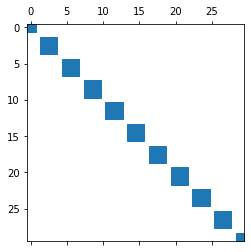

In [207]:
from scipy.sparse import csr_array, dok_array
A = dok_array((gdg.N, gdg.N,))
nb = gdg.nb
for i in range(gdg.ne):
    A[nb*i, nb*i] = -0.5
    A[nb*(i+1)-1, nb*(i+1)-1] = 0.5
    if i > 0:
        A[nb*i, nb*i-1] = -0.5
    if i < gdg.ne-1:
        A[nb*(i+1)-1, nb*(i+1)] = 0.5
# Wall boundary condition at bottom
A[-1,-1] = 1
A = A.tocsr()
plt.spy(A)

# Constuct boundary load vector
p_top = 1e5
b = dok_array((gdg.N, 1,))
b[0] = -0.5 * p_top
b = b.tocsr()
# plt.spy(b)

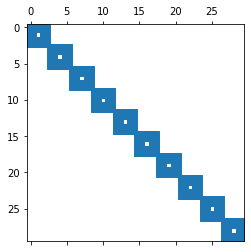

In [208]:
# Copy solver to avoid side effects
s0 = copy.deepcopy(solver)

# Compute
#   int <phi,phi'> dx over each element in physical space

# Basis evaluated at quadrature points, times quad weights in physical space
# [nq, nb] x [nq, 1] x [ne, nq, 1] -> [ne, nq, nb]
u = np.einsum('jn, jm, ijm -> ijn', 
  solver.basis.get_values(solver.elem_helpers.quad_pts),
  solver.elem_helpers.quad_wts,
  solver.elem_helpers.djac_elems)
# [ne, nq, nb1, ndims] x [ne, nq, nb2] -> [ne, nb1, nb2]
B_vec = np.einsum('ijml, ijn -> imn',
  solver.elem_helpers.basis_phys_grad_elems,
  u)
B = dok_array((gdg.N, gdg.N,))
nb = gdg.nb
for i in range(gdg.ne):
  B[nb*i:nb*(i+1), nb*i:nb*(i+1)] = B_vec[i,:,:]
B = B.tocsr()
plt.spy(B)

42.88357002400154

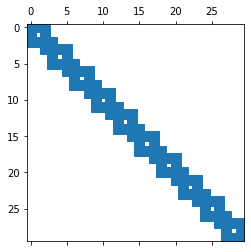

In [209]:
plt.spy(A-B)
np.linalg.cond((A-B).todense())

array([[16.000000000000004,  8.               , -4.               ],
       [ 8.               , 63.99999999999997 ,  8.               ],
       [-4.               ,  8.               , 16.000000000000004]])

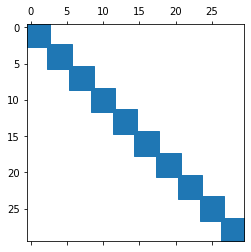

In [216]:
# Assume Uq is computed at solver.x_elems
Uq = helpers.evaluate_state(solver.state_coeffs, solver.elem_helpers.basis_val,
        skip_interp=solver.basis.skip_interp)

from physics.multiphasevpT.functions import GravitySource
gsource = GravitySource()
Sq = gsource.get_source(
    solver.physics,
    Uq,
    solver.elem_helpers.x_elems,
    solver.time)

# Calculate source term quadrature [ne, nq, ns]
Sq_quad = np.einsum('ijk, jm, ijm -> ijk', 
    Sq, 
    solver.elem_helpers.quad_wts,
    solver.elem_helpers.djac_elems)
# Calculate residual
res_elem = np.einsum('jn, ijk -> ink', basis_val, Sq_quad) # [ne, nb, ns]
res_elem.shape

# [nq, nb] x [nq, 1] x [ne, nq, 1] -> [ne, nq, nb]
u = np.einsum('jn, jm, ijm -> ijn', 
  solver.basis.get_values(solver.elem_helpers.quad_pts),
  solver.elem_helpers.quad_wts,
  solver.elem_helpers.djac_elems)
# [nq, nb1] x [ne, nq, nb2] -> [ne, nb1, nb2]
M_vec = np.einsum('jm, ijn -> imn',
  solver.basis.get_values(solver.elem_helpers.quad_pts),
  u)

# Looks like mass matrix here is 1/2 as large as it should be; the following
# gives the integral over [-1,1] (segment with length 2, rather than 1)
M_vec[0,:,:] / (gdg.x[1] - gdg.x[0])

# M Assembly
M = dok_array((gdg.N, gdg.N,))
nb = gdg.nb
for i in range(gdg.ne):
  M[nb*i:nb*(i+1), nb*i:nb*(i+1)] = M_vec[i,:,:]
M = M.tocsr()
plt.spy(M)
M[0:3,0:3].todense()

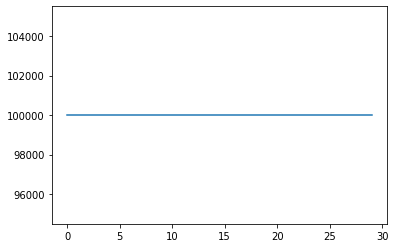

In [211]:
# Testing against zero source term
# (A-B) \ -b
p_const = scipy.sparse.linalg.spsolve(A-B, -b)
plt.plot(p_const)

Target pressure: 1.21e+07
Residual: 3.05e-09


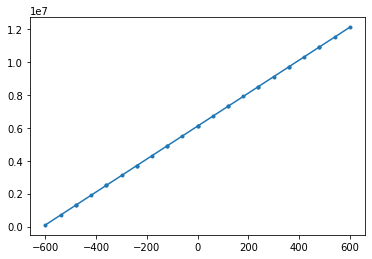

In [266]:
# Testing against constant source term
rho0 = 1000
g = 10
p_like = 0.0*b.todense() + 1.0
f = -b + (rho0*g) * M @ p_like
# f = -b - (rho0*g) * M @ (1+1e-2*p.^0.5)
p_lin = scipy.sparse.linalg.spsolve(A-B, f)
plt.plot(gdg.x, p_lin, '.-')
print(f"Target pressure: {1e5+rho0*g*np.abs(gdg.x[-1]-gdg.x[0]):.2e}")
print(f"Residual: {np.linalg.norm((A-B)@np.expand_dims(p_lin,axis=1) - f, 'fro'):.2e}")

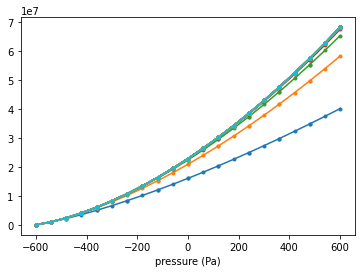

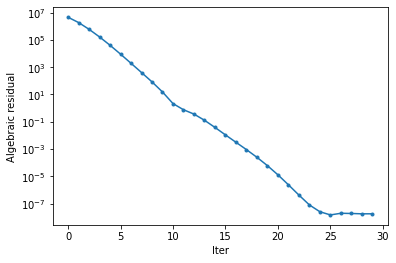

In [282]:
# Testing against constant source term
rho0 = 1000
g = 10
p_like = 0.0*b.todense() + 1.0
f_fn = lambda p : -b + (rho0*g) * M @ (1+1e-2*np.abs(p/1e2)**0.5)
p_nonlin = p_lin
fixedpointiter = lambda p: scipy.sparse.linalg.spsolve(A-B, f_fn(np.expand_dims(p,axis=1)))

# Residual in algebraic equation
evalresidual = lambda p : np.linalg.norm(
  (A-B)@np.expand_dims(p,axis=1) - f_fn(np.expand_dims(p,axis=1)), 'fro')
N_iter = 30
residuals = np.zeros(N_iter)
for i in range(N_iter):
  p_nonlin = fixedpointiter(p_nonlin)
  plt.plot(gdg.x, p_nonlin, '.-')
  residuals[i] = evalresidual(p_nonlin)

plt.xlabel("depth (m)")
plt.xlabel("pressure (Pa)")
plt.figure()
plt.semilogy(residuals, '.-')
plt.xlabel("Iter")
plt.ylabel("Algebraic residual")
plt.show()

In [ ]:
# Test unsteady problem residual

# Reconstruct Uq from known pressure and ns-1 constraints
pass

# Compute residual
res =  np.zeros_like(Uq)
solver.get_residual(Uq, res)
momentum_residual = res[solver.physics.get_state_index("XMomentum")]

In [121]:
''' Work block for testing '''

# Construct phi.phi' (interior) matrix
# B = dok_array((gdg.N, gdg.N,))
# for i in range(gdg.ne):
#     B(2*i-1:2*i, 2*i-1:2*i) = [-0.5, -0.5; 0.5, 0.5]
# end
# # Construct phi.phi mass matrix
# M = sparse(2*N, 2*N);
# for i = 1:N
#     M(2*i-1:2*i, 2*i-1:2*i) = [1/3, 1/6; 1/6, 1/3];
# end
s0 = copy.deepcopy(solver)
# Shorthand the state coefficients at nodes
Uc = s0.state_coeffs
# Shorthand the state at interpolation points
Uq = helpers.evaluate_state(Uc, s0.elem_helpers.basis_val,
      skip_interp=s0.basis.skip_interp)

# # Compute (u^2 + p) . grad(phi)
Fq = s0.physics.get_conv_flux_interior(Uq)[0].shape # [ne, nq, ns, ndims]
# # TODO: insert p computation in interior, expand dims in axis=2
# import solver.tools as solver_tools
# np.ones(gdg.eltwise_shape).shape
# def calculate_phi_gradphi(solver, Fq):
if True:
      quad_wts = solver.elem_helpers.quad_wts # [nq, 1]
      # evaluated gradient of the basis function in physical space
      basis_phys_grad_elems = solver.elem_helpers.basis_phys_grad_elems
            # [ne, nq, nb, ndims]
      djac_elems = solver.elem_helpers.djac_elems # [ne, nq, 1] for elementwise det(J)

      # Calculate flux quadrature
      Fq = np.expand_dims(np.ones(gdg.eltwise_shape),axis=2)
      F_quad = np.einsum('ijkl, jm, ijm -> ijkl', Fq, quad_wts, djac_elems)
            # [ne, nq, ns, ndims]
      '''Calculate residual'''
      # for each element i
      # sum over j [nq]
      # for each n [nb]
      # sum over l [ndims]
      # 'ijnl, ijkl -> ink'
      res = np.einsum('ijnl, ijkl -> ink', basis_phys_grad_elems, F_quad)
            # [ne, <nq>, nb, ns]

      # [ne, nq, nb, ndims], [nq, 1], [ne, nq, 1]
      # ijnl, j
      # np.einsum('ijnl, jm, ijm, -> ink', basis_phys_grad_elems, quad_wts, djac_elems)
      # return (res, basis_phys_grad_elems, F_quad)

# fdotgradph, basis_phys_grad_elems, F_quad = calculate_phi_gradphi(s0,
#       np.expand_dims(np.ones(gdg.eltwise_shape),axis=2)) # [ne, nb, ns]


dir(s0.basis)
# Evaluate basis at nodes (should be identity):
s0.basis.get_basis_val_grads(solver.basis.get_nodes(solver.order))
# print(s0.basis.basis_val)

# Evaluate 
s0.elem_helpers.basis_val
s0.basis.get_values(s0.elem_helpers.quad_pts) #[nq, nb]

# Basis with quadrature weights in physical space
# [nq, nb] x [nq, 1] x [ne, nq, 1] -> [ne, nq, nb]
u = np.einsum('jn, jm, ijm -> ijn', s0.basis.get_values(s0.elem_helpers.quad_pts), quad_wts, djac_elems)
# [ne, nq, nb1, ndims] x [ne, nq, nb2] -> [ne, nb1, nb2]
res = np.einsum('ijml, ijn -> imn', basis_phys_grad_elems, u)

array([[-0.5              , -0.666666666666667,  0.166666666666667],
       [ 0.666666666666667,  0.               , -0.666666666666667],
       [-0.166666666666667,  0.666666666666667,  0.5              ]])

In [ ]:
''' Work block for testing components of <phi, phi> construction'''
import numerics.basis.tools as basis_tools
basis_tools.get_lagrange_basis_1D(s0.elem_helpers.quad_pts, xnodes, basis_val)
# Unpacking basis_tools.get_lagrange_basis_1D
xnodes = s0.basis.get_1d_nodes(-1., 1., 2+1)
nq = 3
nb = 3
basis_val = np.zeros([nq, nb])
nnodes = xnodes.shape[0]
mask = np.ones(nnodes, bool)
basis_val[:] = 1.
for j in range(xnodes.shape[0]):
      mask[j] = False
      basis_val[:,j] = np.prod((s0.elem_helpers.quad_pts - xnodes[mask])/(xnodes[j] - xnodes[
                  mask]), axis=1)
      print(j)
      print(basis_val[:,j])
      mask[j] = True

In [ ]:
''' Testing gdg ravel/inv_ravel '''
# Test inverse ravel operation
from numpy.random import rand
# Perturb initial data with random noise
test_data = rand(*eltwise_shape) * (1.0 + p)
# Compute error introduced by data rearrangement
viol = norm(gdg.inv_ravel(test_data.ravel()) - test_data)
print(viol)

In [ ]:
# Residual evaluation
res =  np.zeros_like(s0.state_coeffs)
s0.get_element_residuals(s0.state_coeffs, res)
# print(res)

import solver.tools as solver_tools

Uq = s0.state_coeffs
Sq = np.zeros_like(Uq) # [ne, nq, ns]
Sq = s0.physics.eval_source_terms(Uq, s0.elem_helpers.x_elems, s0.time, Sq)
    # [ne, nq, ns]
solver_tools.calculate_source_term_integral(
					s0.elem_helpers, Sq)

print(Sq)

In [ ]:
# [S for S in s0.physics.source_terms if S.name == "GravitySource"] 
# Assume source term 0 is gravity
# dir(s0.physics.source_terms[0].get_jacobian)
# s0.physics.source_terms[0].get_jacobian(
#   s0.physics, s0.state_coeffs, s0.mesh.node_coords, s0.time\
#   )
# s0.mesh.node_coords
# s0.physics.get_state_slice("pDensityWv")

relax_param = 0.01

# R = s0.physics.compute_additional_variable["Pressure"] - s0.physics.source_terms[0]
# p = s0.physics.compute_additional_variable("Pressure", s0.state_coeffs, True)
# S =  -s0.physics.source_terms[0].get_source(
#       s0.physics, s0.state_coeffs, s0.mesh.node_coords, s0.time)

In [ ]:
''' Gradient descent strategy for minimizing the steady-state residual'''

p_top = 1e5 # Specify boundary condition at top: pressure = p_atm
s0 = copy.deepcopy(solver)

# def eval_relaxeqn(s0):
if True:
	''' Compute gradients of hydrostatic equation residual with respect to all states'''
	# Shorthand the state coefficients at nodes
	Uc = s0.state_coeffs
	# Shorthand the state at interpolation points
	Uq = helpers.evaluate_state(s0.state_coeffs, s0.elem_helpers.basis_val,
				skip_interp=s0.basis.skip_interp)

	# Compute (u^2 + p) . grad(phi)
	Fq = s0.physics.get_conv_flux_interior(Uq)[0] # [ne, nq, ns, ndims]
	# TODO: insert p computation in interior, expand dims in axis=2
	fdotgradphi = solver_tools.calculate_volume_flux_integral(
						s0, s0.elem_helpers, Fq) # [ne, nb, ns]

	interior_res = np.zeros_like(Uq)
	solver.get_interior_face_residuals(Uq, interior_res)
	dinterior_res = dpdq * interior_res

	# Manual hack
	bdry_res = np.zeros_like(Uq)
	solver.get_boundary_face_residuals(Uq, bdry_res)
	# Override bdry pressure
	bdry_res[-1,:,s0.physics.get_state_index("XMomentum")] = -p_top
	dbdry_res = dpdq * bdry_res

	# Compute dS/dq (ne, nd, nq), where S = -rho*g
	dSdq = s0.physics.source_terms[0].get_jacobian(
		s0.physics, s0.state_coeffs, s0.mesh.node_coords, s0.time\
		)[:,:,s0.physics.get_state_index("XMomentum"),:]
	# Compute S . phi == (-rho*g) . phi
	Sq = np.zeros_like(Uq)
	Sq = s0.physics.eval_source_terms(Uq, s0.mesh.node_coords, s0.time, Sq) # [ne, nq, ns]
	Sphi = solver_tools.calculate_source_term_integral(
			s0.elem_helpers, Sq) # [ne, nb, ns]
	# Compute dSdq . phi
	dSphi = solver_tools.calculate_source_term_integral(
			s0.elem_helpers, dSdq) # [ne, nb, ns]

	# Compute objective residual (sum on RHS) across all indices
	R_all_indices = interior_res + fdotgradphi + Sphi + bdry_res
	# Constrain to pressure index
	R = R_all_indices[:,:,s0.physics.get_momentum_slice()]
	# Compute derivative of residual with respect to state
	dR = dpdqdotgradphi + dSphi + dinterior_res + dbdry_res # [ne, nb, ns]

	# Get quadratic problem
	Q = 0.5 * R**2
	dQ = R * dR

	# return Q, dQ
# print(bdry_res)

In [ ]:
relax_param = 1e-7
s0 = copy.deepcopy(solver)

Q0, dQ = eval_relaxeqn(s0)
# step = np.zeros_like(dQ)
# step[:,:,s0.physics.get_state_index("pDensityWv")] = dQ[:,:,s0.physics.get_state_index("pDensityWv")]
# step[:,:,s0.physics.get_state_index("pDensityM")] = dQ[:,:,s0.physics.get_state_index("pDensityM")]
# dQ.shape

print(f"{norm(Q0):.3e}")

for i in range(100):
        Q, dQ = eval_relaxeqn(s0)

        # Constrain weight ratio, rather than weight fraction (for now)
        ratio = s0.state_coeffs[:,:,s0.physics.get_state_index("pDensityWv")] \
                / s0.state_coeffs[:,:,s0.physics.get_state_index("pDensityM")]

        # Construct step
        v = np.zeros_like(dQ)
        v[:, :, s0.physics.get_state_index("pDensityWv")] = ratio
        v[:, :, s0.physics.get_state_index("pDensityM")] = 1.0
        v /= norm(v, axis=-1, keepdims=True)

        # Evaluate directional derivative
        DvQ = np.einsum("ijk, ijl -> ij", dQ, v)

        step_size = - relax_param * DvQ
        # Step limiting
        step_guess = np.einsum("ij, ijk -> ijk", step_size, v)[:,:,1:3]
        step_size_factor = np.minimum(0.5*np.ones_like(step_guess),
                (1e-11 + np.abs(step_guess)) / (1e-11 + s0.state_coeffs[:,:,1:3])) \
                * (1e-11 + s0.state_coeffs[:,:,1:3]) / (1e-11 + np.abs(step_guess))
        step_size *= np.min(step_size_factor, axis=2)
        
        # DvQ = (Q.squeeze(axis=2)/np.einsum("ijk, ijl -> ij", dQ, v))
        step_dir = np.einsum("ij, ijk -> ijk", step_size, v)
        
        s0.state_coeffs += step_dir
        Q, dQ = eval_relaxeqn(s0)
        print(f"{norm(Q):.3e}")

# Check ratio constraint
# s0.state_coeffs[:,:,s0.physics.get_state_index("pDensityWv")] \
        # / s0.state_coeffs[:,:,s0.physics.get_state_index("pDensityM")]
# print(s0.state_coeffs)
# step_size

print(Q/Q0)

In [ ]:
import numerics.helpers.helpers as helpers
s0 = copy.deepcopy(solver)

p_top = 1e5 # Specify boundary condition at top: pressure = p_atm
def eval_relaxeqn(s0):
# if True:
	''' Compute gradients of hydrostatic equation residual with respect to all states'''
	# Shorthand the state coefficients
	Uq = s0.state_coeffs
	Uq = helpers.evaluate_state(s0.state_coeffs, s0.elem_helpers.basis_val,
				skip_interp=s0.basis.skip_interp)

	# Compute dp/dq (ne, nd, nq)
	dpdq = s0.physics.compute_pressure_sgradient(s0.state_coeffs)
	# Compute (u^2 + p) . grad(phi) == p . grad(phi)
	Fq = s0.physics.get_conv_flux_interior(Uq)[0] # [ne, nq, ns, ndims]
	fdotgradphi = solver_tools.calculate_volume_flux_integral(
						s0, s0.elem_helpers, Fq) # [ne, nb, ns]
	# Compute dp/dq . grad(phi)
	dpdqdotgradphi = solver_tools.calculate_volume_flux_integral(
						s0, s0.elem_helpers, np.expand_dims(dpdq,axis=3)) # [ne, nb, ns]

	interior_res = np.zeros_like(Uq)
	solver.get_interior_face_residuals(Uq, interior_res)
	dinterior_res = dpdq * interior_res

	# Manual hack
	bdry_res = np.zeros_like(Uq)
	solver.get_boundary_face_residuals(Uq, bdry_res)
	# Override bdry pressure
	bdry_res[-1,:,s0.physics.get_state_index("XMomentum")] = -p_top
	dbdry_res = dpdq * bdry_res

	# Compute dS/dq (ne, nd, nq), where S = -rho*g
	dSdq = s0.physics.source_terms[0].get_jacobian(
		s0.physics, s0.state_coeffs, s0.mesh.node_coords, s0.time\
		)[:,:,s0.physics.get_state_index("XMomentum"),:]
	# Compute S . phi == (-rho*g) . phi
	Sq = np.zeros_like(Uq)
	Sq = s0.physics.eval_source_terms(Uq, s0.mesh.node_coords, s0.time, Sq) # [ne, nq, ns]
	Sphi = solver_tools.calculate_source_term_integral(
			s0.elem_helpers, Sq) # [ne, nb, ns]
	# Compute dSdq . phi
	dSphi = solver_tools.calculate_source_term_integral(
			s0.elem_helpers, dSdq) # [ne, nb, ns]

	# Compute objective residual (sum on RHS) across all indices
	R_all_indices = interior_res + fdotgradphi + Sphi + bdry_res
	# Constrain to pressure index
	R = R_all_indices[:,:,s0.physics.get_momentum_slice()]
	# Compute derivative of residual with respect to state
	dR = dpdqdotgradphi + dSphi + dinterior_res + dbdry_res # [ne, nb, ns]

	# Get quadratic problem
	Q = 0.5 * R**2
	dQ = R * dR

	return Q, dQ